In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from atmacup_18 import constants

import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main2/v00/v00_02_00/utils.py'>

In [2]:
RANDOM_STATE = 2024

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]
TRAFFIC_LIGHTS_BBOX_IMAGE_NAME = constants.TRAFFIC_LIGHT_BBOX_IMAGE_NAME

BASE_PRED_DIR = Path("..", "v00_01_00")
BASE_OOF_PRED_CSV = BASE_PRED_DIR.joinpath("oof_preds.csv")
BASE_SUBMISSION_CSV = BASE_PRED_DIR.joinpath("submission.csv")

In [4]:
TARGET_COLS = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

In [5]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320,0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420,1


In [6]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1


In [7]:
def reduce_base_pred(
    df: pl.DataFrame, base_pred_df: pl.DataFrame, has_target: bool
) -> pl.DataFrame:
    """
    基礎推定値のdfをconcatし、元のdfのtarget列から除去したdfを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        base_pred_df (pl.DataFrame): 基礎推定値のDataFrame
        has_target (bool): target列を持つかどうか
    """
    pf = "base_pred_"
    df = pl.concat(
        [df, base_pred_df.select(pl.all().name.prefix(pf))], how="horizontal"
    )

    if has_target:
        target_cols = TARGET_COLS
        df = df.with_columns(
            [
                (pl.col(tg_col) - pl.col(f"{pf}{tg_col}")).alias(tg_col)
                for tg_col in target_cols
            ]
        )
    return df


def add_base_pred_to_target(df: pl.DataFrame, target_cols: list[str]) -> pl.DataFrame:
    """
    target_colsの列に基礎推定量を足したDataFrameを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        target_cols (list[str]): 追加する基礎推定量の列名
    """
    pf = "base_pred_"
    base_pred_cols = [f"{pf}{tg_col}" for tg_col in TARGET_COLS]
    df = df.with_columns(
        [
            (pl.col(tg_col) + pl.col(bp_col)).alias(tg_col)
            for tg_col, bp_col in zip(target_cols, base_pred_cols)
        ]
    )

    return df


if BASE_PRED_DIR is not None:
    # columns: "x_0", "y_0", "z_0", ..., "x_5", "y_5", "z_5"
    base_oof_pred_df = pl.read_csv(BASE_OOF_PRED_CSV)
    base_submission_df = pl.read_csv(BASE_SUBMISSION_CSV)

    # 基礎推定値を元のtarget列から引いた値を新たなtarget列とする
    tr_df = reduce_base_pred(tr_df, base_oof_pred_df, has_target=True)
    ts_df = reduce_base_pred(ts_df, base_submission_df, has_target=False)

## scene_dsec順に並び替える

In [8]:
tr_df = tr_df.sort(["scene_id", "scene_dsec"])
ts_df = ts_df.sort(["scene_id", "scene_dsec"])

## Target

In [9]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, 3.393520993704111e-06, 0.11282975357158784, -2.038206408097059, -0.043909738152819955, 0.00950896763207787, 0.04818955333776209, 1.0677632287781444
$ tg_cood_y_0 <f64> 43371.0, 0.0, -1.4087097480749982e-06, 0.11686747070012159, -2.536280240997724, -0.028446027437594876, -0.000707258251058652, 0.02867632994904526, 3.457441408366276
$ tg_cood_z_0 <f64> 43371.0, 0.0, -1.2900197444211694e-07, 0.04067577464260828, -0.9947331028832211, -0.018896732267768005, 0.00049074647458956, 0.018407894778899075, 1.4497439887269041
$ tg_cood_x_1 <f64> 43371.0, 0.0, 6.899887125939776e-06, 0.30905

## 特徴量

In [10]:
feature = utils.FeatureGBDT(prefix="ft_")
# feature = utils.FeatureRidge(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker']
Rows: 9
Columns: 15
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.6324016778486632, -4.936206340789795, -0.2363678514957428, -1.8347540436410405e-15, 0.22229795157909396, 3.1400704383850098
$ ft_steeringAngleDeg       <f64> 43371.0, 0.0, -2.065172574071012, 65.54882159006848, -481.394287109375, -3.461754322052002, -0.35647091269493103, 2.6269068717956543, 484.69171142578125
$ ft_steeringTorque         <f64>

## モデリング

In [11]:
N_SPLITS = 2

In [12]:
# model_params = {
#    "ridge": {
#        "alpha": 0.1,
#        "random_state": RANDOM_STATE,
#    }
# }
#
# fit_params = {}

model_params = {
    "gbdt": {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "max_depth": 5,
        "max_leaves": 2 ** (4 - 1),
        "bagging_fraction": 0.5,
        "bagging_freq": 1,
        "feature_fraction": 0.9,
        "boosting_type": "gbdt",
        "saved_feature_importance_type": 1,
        "num_threads": 4,
        "seed": RANDOM_STATE,
    }
}

fit_params = {
    "gbdt": {
        "num_boost_round": 1000,
        "early_stopping_rounds": 100,
    }
}

In [13]:
models, oof_preds = utils.train(
    model_class=utils.LgbModel,
    # model_class=utils.RidgeModel,
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 21685, number of used features: 11
[LightGBM] [Info] Start training from score -0.001053
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.105522	valid's rmse: 0.108765
[100]	train's rmse: 0.102445	valid's rmse: 0.106242
[150]	train's rmse: 0.100646	valid's rmse: 0.104789
[200]	train's rmse: 0.099456	valid's rmse: 0.103826
[250]	train's rmse: 0.0986776	valid's rmse: 0.103221
[300]	train's rmse: 0.0980954	valid's rmse: 0.102779
[350]	train's rmse: 0.0976379	valid's rmse: 0.102477
[400]	train's rmse: 0.0973019	valid's rmse: 0.102252
[450]	train's rmse: 0.097019	valid's rmse: 0.10207
[500]	train's rmse: 0.09676

/home/tatsuya/projects/atmacup/atmacup_18/venv/lib/python3.10/site-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1140
[LightGBM] [Info] Number of data points in the train set: 21686, number of used features: 11
[LightGBM] [Info] Start training from score 0.001059
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.108638	valid's rmse: 0.105854
[100]	train's rmse: 0.105887	valid's rmse: 0.102971
[150]	train's rmse: 0.104241	valid's rmse: 0.101358
[200]	train's rmse: 0.103137	valid's rmse: 0.100303
[250]	train's rmse: 0.102406	valid's rmse: 0.0996476
[300]	train's rmse: 0.101901	valid's rmse: 0.0992424
[350]	train's rmse: 0.101529	valid's rmse: 0.0989539
[400]	train's rmse: 0.101219	valid's rmse: 0.098749
[450]	train's rmse: 0.100936	valid's rmse: 0.0985685
[500]	train's rmse: 0.10070

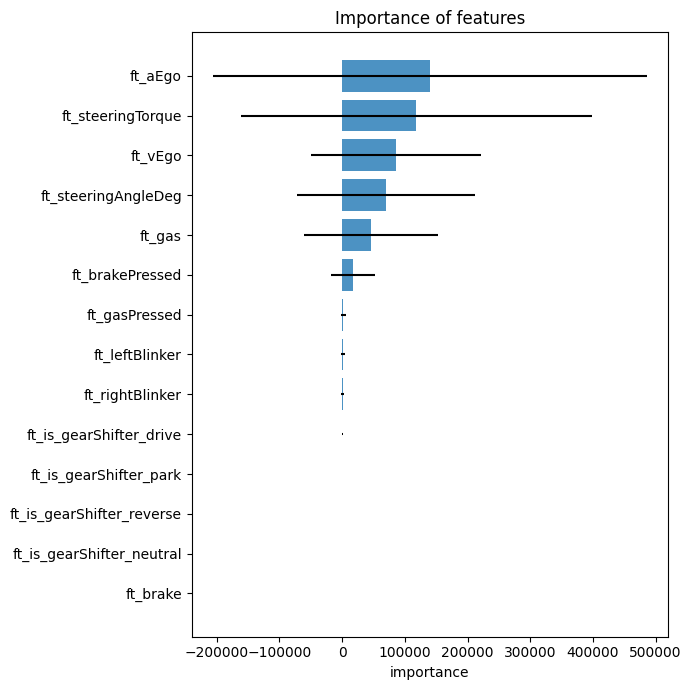

In [14]:
utils.plot_lgb_importance(
    sum([model.models for model in models], []), models[0].feature_names
)

In [15]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,…,tg_cood_y_4,tg_cood_z_4,tg_cood_x_5,tg_cood_y_5,tg_cood_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,ft_brake,ft_brakePressed,ft_gas,ft_gasPressed,ft_is_gearShifter_drive,ft_is_gearShifter_neutral,ft_is_gearShifter_park,ft_is_gearShifter_reverse,ft_leftBlinker,ft_rightBlinker,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,0.275953,0.030123,0.04506,0.848514,0.062986,0.107454,1.581246,0.122747,0.20232,2.471926,0.162879,0.300742,3.759697,0.176424,0.403755,5.346518,0.204624,0.482125,"""00066be8e20318869c38c66be46663…",320,0,2.553638,0.002104,0.000127,5.383485,…,0.176424,0.403755,5.346518,0.204624,0.482125,5.701526,1.538456,-2.165777,-139.0,0.0,0.0,0.25,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.098012,-0.008655,0.0079,0.524088,-0.043583,0.017286,1.167056,-0.099428,0.032211,2.010934,-0.173064,0.055185,2.978746,-0.256354,0.080669,4.071501,-0.339502,0.110288
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,-0.057243,-0.009974,0.003127,-0.251872,-0.037419,-0.024518,-0.392099,0.07561,0.00287,-0.569692,0.378471,0.029025,-0.904556,0.824557,0.056796,-1.332431,1.399131,0.06432,"""00066be8e20318869c38c66be46663…",420,1,5.027511,0.002037,0.001901,10.60236,…,0.824557,0.056796,-1.332431,1.399131,0.06432,11.176292,0.279881,-11.625697,-44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.001101,-0.055077,-0.000021,-0.012586,-0.187291,0.000331,-0.068612,-0.396327,0.00165,-0.156004,-0.626253,0.003004,-0.334217,-0.89292,-0.000274,-0.55052,-1.214524,-0.003744
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,0.10619,-0.002859,0.015904,0.222013,-0.032571,0.022771,0.307383,-0.163648,0.035193,0.289995,-0.368223,0.052128,0.179658,-0.592891,0.095377,-0.18519,-0.863841,0.144872,"""00066be8e20318869c38c66be46663…",520,2,4.709511,0.002046,0.001673,9.931509,…,-0.592891,0.095377,-0.18519,-0.863841,0.144872,10.472548,0.231099,-2.985105,-132.0,0.0,0.0,0.18,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.032627,-0.01349,0.001246,0.13575,-0.057343,0.004454,0.289191,-0.130961,0.009563,0.480067,-0.215422,0.01401,0.706006,-0.324194,0.016694,0.938728,-0.451092,0.026692
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,0.07583,-0.043982,-0.008201,0.564993,-0.127167,-0.01281,1.37644,-0.238669,-0.01228,2.41312,-0.377023,-0.003694,3.644594,-0.543336,0.011268,5.070384,-0.760149,0.04382,"""000fb056f97572d384bae4f5fc1e0f…",20,4,1.476031,0.002132,-0.000646,3.110169,…,-0.543336,0.011268,5.070384,-0.760149,0.04382,3.316744,1.276733,-31.725477,-114.0,0.0,0.0,0.255,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.084425,-0.04944,0.005766,0.563111,-0.161953,0.012195,1.344992,-0.290129,0.022332,2.362151,-0.435767,0.036406,3.571908,-0.622812,0.049882,4.840105,-0.781474,0.076724
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,0.098991,0.031631,0.005658,0.254402,0.134801,0.015476,0.468381,0.320369,0.030009,0.668361,0.60178,0.02944

## 評価

In [16]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = TARGET_COLS

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.06090026661960987,
 'score_pred_tg_cood_y_0': 0.03404554367490462,
 'score_pred_tg_cood_z_0': 0.02613171156699316,
 'score_pred_tg_cood_x_1': 0.13245276382612306,
 'score_pred_tg_cood_y_1': 0.07920774535238805,
 'score_pred_tg_cood_z_1': 0.05435630046499271,
 'score_pred_tg_cood_x_2': 0.236285267446286,
 'score_pred_tg_cood_y_2': 0.14501889807382687,
 'score_pred_tg_cood_z_2': 0.08381317450101135,
 'score_pred_tg_cood_x_3': 0.39138850262772407,
 'score_pred_tg_cood_y_3': 0.24169834502025492,
 'score_pred_tg_cood_z_3': 0.11462015030671746,
 'score_pred_tg_cood_x_4': 0.6082639238700175,
 'score_pred_tg_cood_y_4': 0.3767706913007972,
 'score_pred_tg_cood_z_4': 0.1467548704927278,
 'score_pred_tg_cood_x_5': 0.8927178939063548,
 'score_pred_tg_cood_y_5': 0.551380602231568,
 'score_pred_tg_cood_z_5': 0.1802018197024832,
 'avg': 0.2420004706102655}

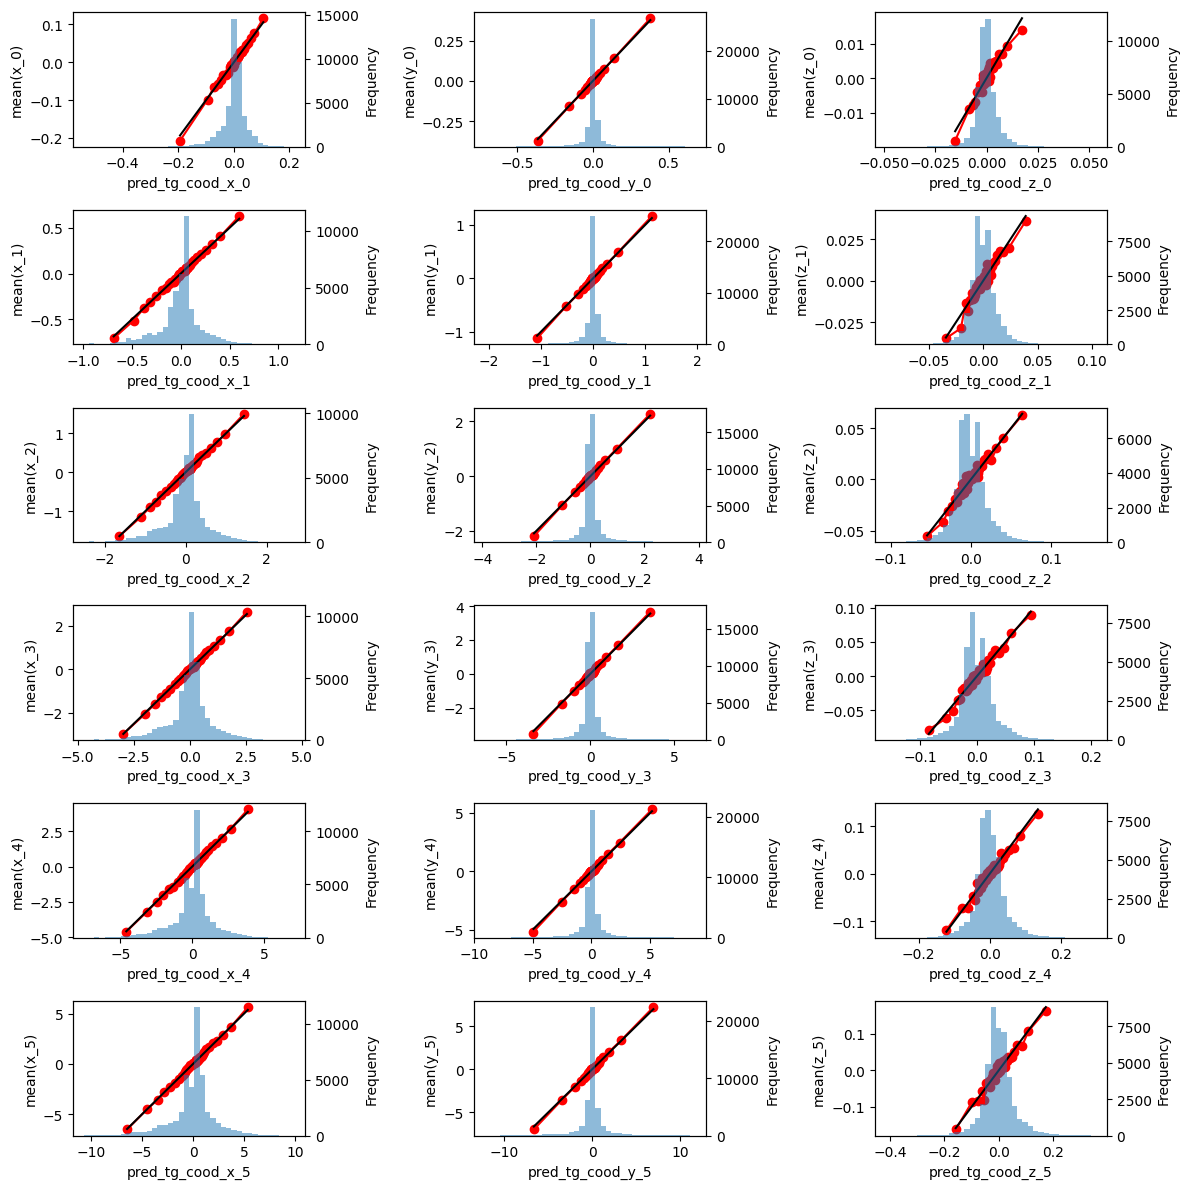

In [17]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

In [18]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    tr_df = add_base_pred_to_target(tr_df, TARGET_COLS)
    tr_df = add_base_pred_to_target(tr_df, pred_cols)

In [19]:
if BASE_PRED_DIR is not None:
    scores = calc_score(tr_df, pred_cols)
    display(scores)

{'score_pred_tg_cood_x_0': 0.06090026661960987,
 'score_pred_tg_cood_y_0': 0.03404554367490462,
 'score_pred_tg_cood_z_0': 0.02613171156699316,
 'score_pred_tg_cood_x_1': 0.13245276382612306,
 'score_pred_tg_cood_y_1': 0.07920774535238803,
 'score_pred_tg_cood_z_1': 0.05435630046499271,
 'score_pred_tg_cood_x_2': 0.236285267446286,
 'score_pred_tg_cood_y_2': 0.14501889807382687,
 'score_pred_tg_cood_z_2': 0.08381317450101136,
 'score_pred_tg_cood_x_3': 0.39138850262772407,
 'score_pred_tg_cood_y_3': 0.24169834502025492,
 'score_pred_tg_cood_z_3': 0.11462015030671746,
 'score_pred_tg_cood_x_4': 0.6082639238700175,
 'score_pred_tg_cood_y_4': 0.3767706913007972,
 'score_pred_tg_cood_z_4': 0.1467548704927278,
 'score_pred_tg_cood_x_5': 0.8927178939063548,
 'score_pred_tg_cood_y_5': 0.551380602231568,
 'score_pred_tg_cood_z_5': 0.1802018197024832,
 'avg': 0.2420004706102655}

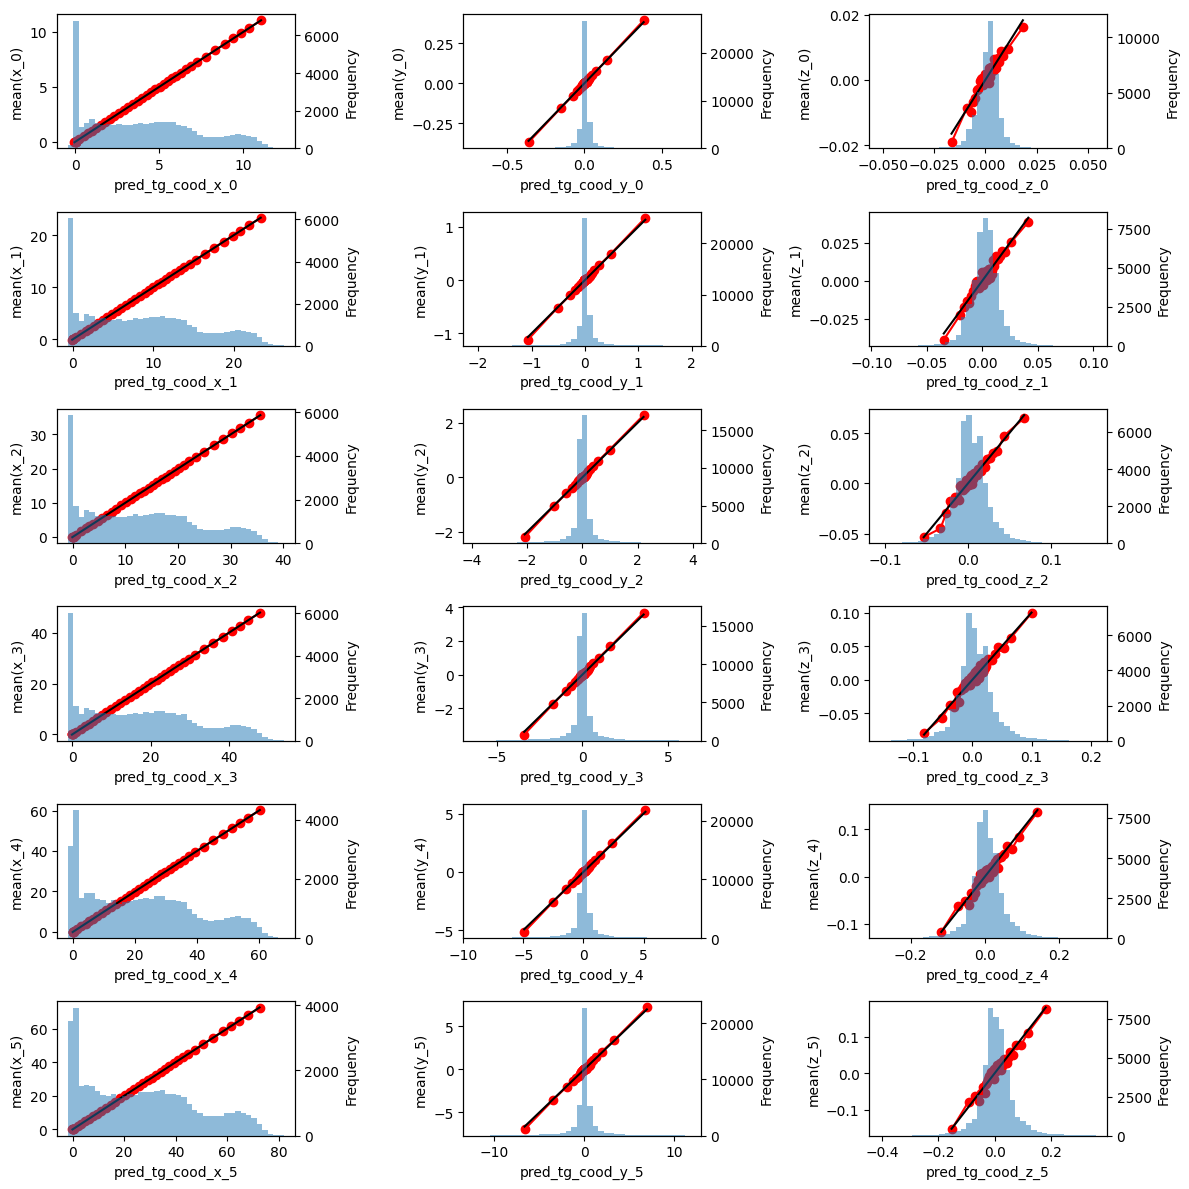

In [20]:
if BASE_PRED_DIR is not None:
    utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## oofを保存

In [21]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = TARGET_COLS

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


# 元の順番に戻して保存
create_submission_csv(tr_df.sort("origin_idx").select(pred_cols), "oof_preds.csv")

Submission file is created: oof_preds.csv


## Submission

In [22]:
preds = utils.predict(
    models,
    ts_df,
    feature.columns,
    pred_cols=pred_cols,
)
pred_cols = preds.columns
ts_df = pl.concat([ts_df, preds], how="horizontal")

preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.01399,-0.053127,0.000611,-0.044899,-0.137823,0.001078,-0.08923,-0.241101,0.000261,-0.13973,-0.323329,-0.000747,-0.255991,-0.382552,-0.005605,-0.378079,-0.503753,-0.004989
-0.128662,0.393505,-0.003759,-0.411934,0.989224,-0.006855,-0.817929,1.726169,-0.013725,-1.39719,2.489669,-0.019954,-2.044713,3.380639,-0.017817,-2.758676,4.279499,-0.006687
-0.025425,0.016446,-0.002693,-0.137641,0.035652,-0.008072,-0.393321,0.066868,-0.013161,-0.788257,0.072927,-0.015638,-1.289496,0.100084,-0.023066,-1.875533,0.121526,-0.029529
-0.059874,0.057143,-0.008458,-0.22582,0.17008,-0.019852,-0.542023,0.35394,-0.032496,-0.991762,0.658694,-0.0431,-1.557027,1.097477,-0.060308,-2.143807,1.613465,-0.072597
-0.158923,0.008806,-0.011204,-0.627215,0.025615,-0.032021,-1.308853,0.055319,-0.050528,-2.098434,0.089739,-0.064814,-2.896785,0.137938,-0.079593,-3.5964,0.186401,-0.095032
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000016,0.01331,0.005855,0.018775,0.061405,0.017031,0.051795,0.14574,0.025558,0.111607,0.268288,0.032597,0.19355,0.418222,0.03872,0.312322,0.594254,0.048786
0.009435,-0.00786,0.003823,0.121251,-0.038281,0.010244,0.352062,-0.09281,0.024051,0.669625,-0.165011,0.0403,1.056657,-0.247422,0.057675,1.49991,-0.35333,0.079016
0.002223,-0.010471,-0.000572,0.042367,-0.046063,-0.001739,0.133297,-0.102869,-0.002044,0.273122,-0.1779,-0.000459,0.453348,-0.259784,0.004139,0.696239,-0.352427,0.00922


In [23]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    ts_df = add_base_pred_to_target(ts_df, pred_cols)
    display(ts_df)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,base_pred_y_1,base_pred_z_1,base_pred_x_2,base_pred_y_2,base_pred_z_2,base_pred_x_3,base_pred_y_3,base_pred_z_3,base_pred_x_4,base_pred_y_4,base_pred_z_4,base_pred_x_5,base_pred_y_5,base_pred_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,ft_brake,ft_brakePressed,ft_gas,ft_gasPressed,ft_is_gearShifter_drive,ft_is_gearShifter_neutral,ft_is_gearShifter_park,ft_is_gearShifter_reverse,ft_leftBlinker,ft_rightBlinker,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0,1.503265,0.001723,-0.000658,3.168907,0.001657,-0.000764,4.830752,-0.001041,-0.000387,6.487332,-0.006141,0.00024,8.14054,-0.014065,0.000802,9.791179,-0.02427,0.001378,3.374273,-0.01936,-34.008415,17.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.489275,-0.051403,-0.000047,3.124008,-0.136166,0.000314,4.741522,-0.242141,-0.000127,6.347602,-0.329471,-0.000507,7.884549,-0.396616,-0.004804,9.4131,-0.528022,-0.003611
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1,1.081685,0.001687,-0.000965,2.279532,0.001203,-0.001308,3.474776,-0.002297,-0.00109,4.666364,-0.008579,-0.000562,5.85659,-0.018126,-0.000037,7.0466,-0.030361,0.00053,2.441048,-0.022754,307.860077,295.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.953023,0.395192,-0.004724,1.867597,0.990426,-0.008163,2.656847,1.723873,-0.014815,3.269174,2.48109,-0.020516,3.811877,3.362513,-0.017854,4.287924,4.249138,-0.006157
"""012baccc145d400c896cb82065a93d…",3.604152,-0.286239,10.774388,-110.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",320,2,1.607112,0.001732,-0.000583,3.387984,0.001769,-0.00063,5.164766,-0.000732,-0.000214,6.935885,-0.005541,0.000437,8.703138,-0.013064,0.001008,10.467242,-0.022769,0.001587,3.604152,-0.286239,10.774388,-110.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.581687,0.018179,-0.003275,3.250343,0.03742,-0.008702,4.771445,0.066137,-0.013375,6.147628,0.067387,-0.015201,7.413643,0.087019,-0.022058,8.591709,0.098757,-0.027943
"""012baccc145d400c896cb82065a93d…",2.048902,-0.537628,61.045235,189.0,0.0,true,0.0,false,"""drive""",true,false,"""012baccc145d400c896cb82065a93d…",420,3,0.904534,0.001672,-0.001094,1.905811,0.001012,-0.001537,2.904988,-0.002824,-0.001386,3.901184,-0.009604,-0.000899,4.896863,-0.019832,-0.000389,5.893314,-0.032921,0.000174,2.048902,-0.537628,61.045235,189.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.844661,0.058815,-0.009552,1.679991,0.171092,-0.021389,2.362965,0.351116,-0.033882,2.909422,0.64909,-0.043999,3.339837,1.077645,-0.060697,3.749508,1.580544,-0.072423
"""01d738e799d260a10f6324f78023b3…",2.201528,-1.8986,5.740093,-41.0,0.0,true,0.0,false,"""drive""",false,false,"""01d738e799d260a10f6324f78023b3…",120,4,0.973483,0.001678,-0.001044,2.051266,0.001086,-0.001448,3.126754,-0.002619,-0.001271,4.198998,-0.009205,-0.000768,5.270397,-0.019168,-0.000252,6.342182,-0.031925,0.000312,2.201528,-1.8986,5.740093,-41.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.81456,0.010484,-0.012248,1.424051,0.026701,-0.033469,1.817901,0.0527,-0.051799,2.100564,0.080534,-0.065582,2.373612,0.11877,-0.079845

In [24]:
# 元の順番に戻す
ts_df = ts_df.sort("origin_idx")

In [25]:
create_submission_csv(ts_df.select(pred_cols), "submission.csv")

Submission file is created: submission.csv
